In [5]:
def build_model_path(sparsity, beta, threshold):
    sparsity = '0' if sparsity == 0 else sparsity
    threshold = '1' if threshold == 1 else threshold
    return f'./models/experiment_layer_development_investigation/best_grid_search_sparsity_{sparsity}_beta_{beta}_threshold_{threshold}.pth'


# Sparsity evaluation

In [1]:
from glob import glob
import json
import pandas as pd

files = glob('./output/experiments_layer_development_investigation/*.json')

all_dicts = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)
        all_dicts.append(data)

sparsity_evaluation = pd.DataFrame(all_dicts)

sparsity_evaluation["average_training_time_per_epoch"] = sparsity_evaluation["time"] / sparsity_evaluation["epochs"]

sparsity_evaluation = sparsity_evaluation[(sparsity_evaluation["beta"] == 0.99) & (sparsity_evaluation["threshold"] == 1)]

sparsity_evaluation = (sparsity_evaluation.sort_values("sparsity", ascending=False))[["epochs", "test_accuracy", "sparsity", "beta", "threshold", "average_training_time_per_epoch"]]

sparsity_evaluation

epochs  test_accuracy  sparsity  beta  threshold  \
6        8      39.620141      0.95  0.99        1.0   
11       7      42.005300      0.70  0.99        1.0   
1        8      72.217314      0.20  0.99        1.0   
16      10      70.229682      0.00  0.99        1.0   

    average_training_time_per_epoch  
6                        763.265529  
11                       771.712926  
1                        774.047120  
16                       482.918441

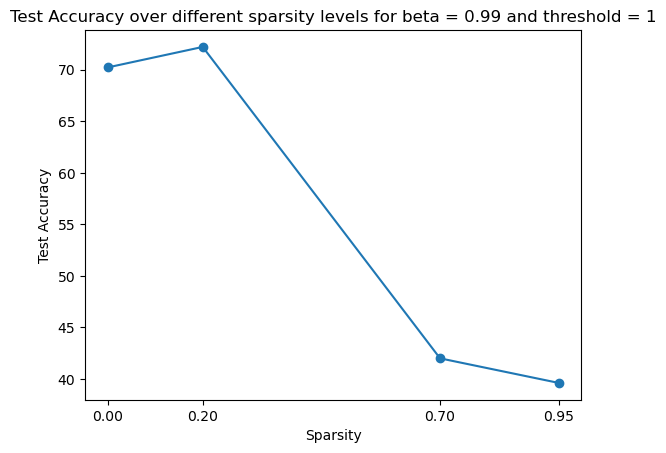

In [2]:
import matplotlib.pyplot as plt

x = sparsity_evaluation["sparsity"].to_numpy()
y = sparsity_evaluation["test_accuracy"].to_numpy()

plt.title("Test Accuracy over different sparsity levels for beta = 0.99 and threshold = 1")
plt.xlabel("Sparsity")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0, 0.2, 0.7, 0.95])
plt.plot(x,y, marker='o')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

x = sparsity_evaluation["sparsity"].to_numpy()
y = sparsity_evaluation["average_training_time_per_epoch"].to_numpy()

plt.title("Average Training Time over different sparsity levels for beta = 0.99 and threshold = 1")
plt.xlabel("Sparsity")
plt.ylabel("Average Training Time")
plt.xticks(ticks=[0, 0.2, 0.7, 0.95])
plt.plot(x,y, marker='o')

plt.show()

In [19]:
from training.pruning import apply_random_weight_pruning_mask, make_pruning_permanent

model = copy.deepcopy(base_net)
model_path = build_model_path(0.95, beta, threshold)

model = apply_random_weight_pruning_mask(model, 0.95)
print(model_path)
model.load_state_dict(torch.load(model_path))

model = make_pruning_permanent(model)

torch.save(model.state_dict(), model_path)


./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.99_threshold_1.pth


In [6]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

beta = 0.99
threshold = 1
sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    models.append(model)

./models/experiment_layer_development_investigation/best_grid_search_sparsity_0_beta_0.99_threshold_1.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.99_threshold_1.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.99_threshold_1.pth
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.99_threshold_1.pth


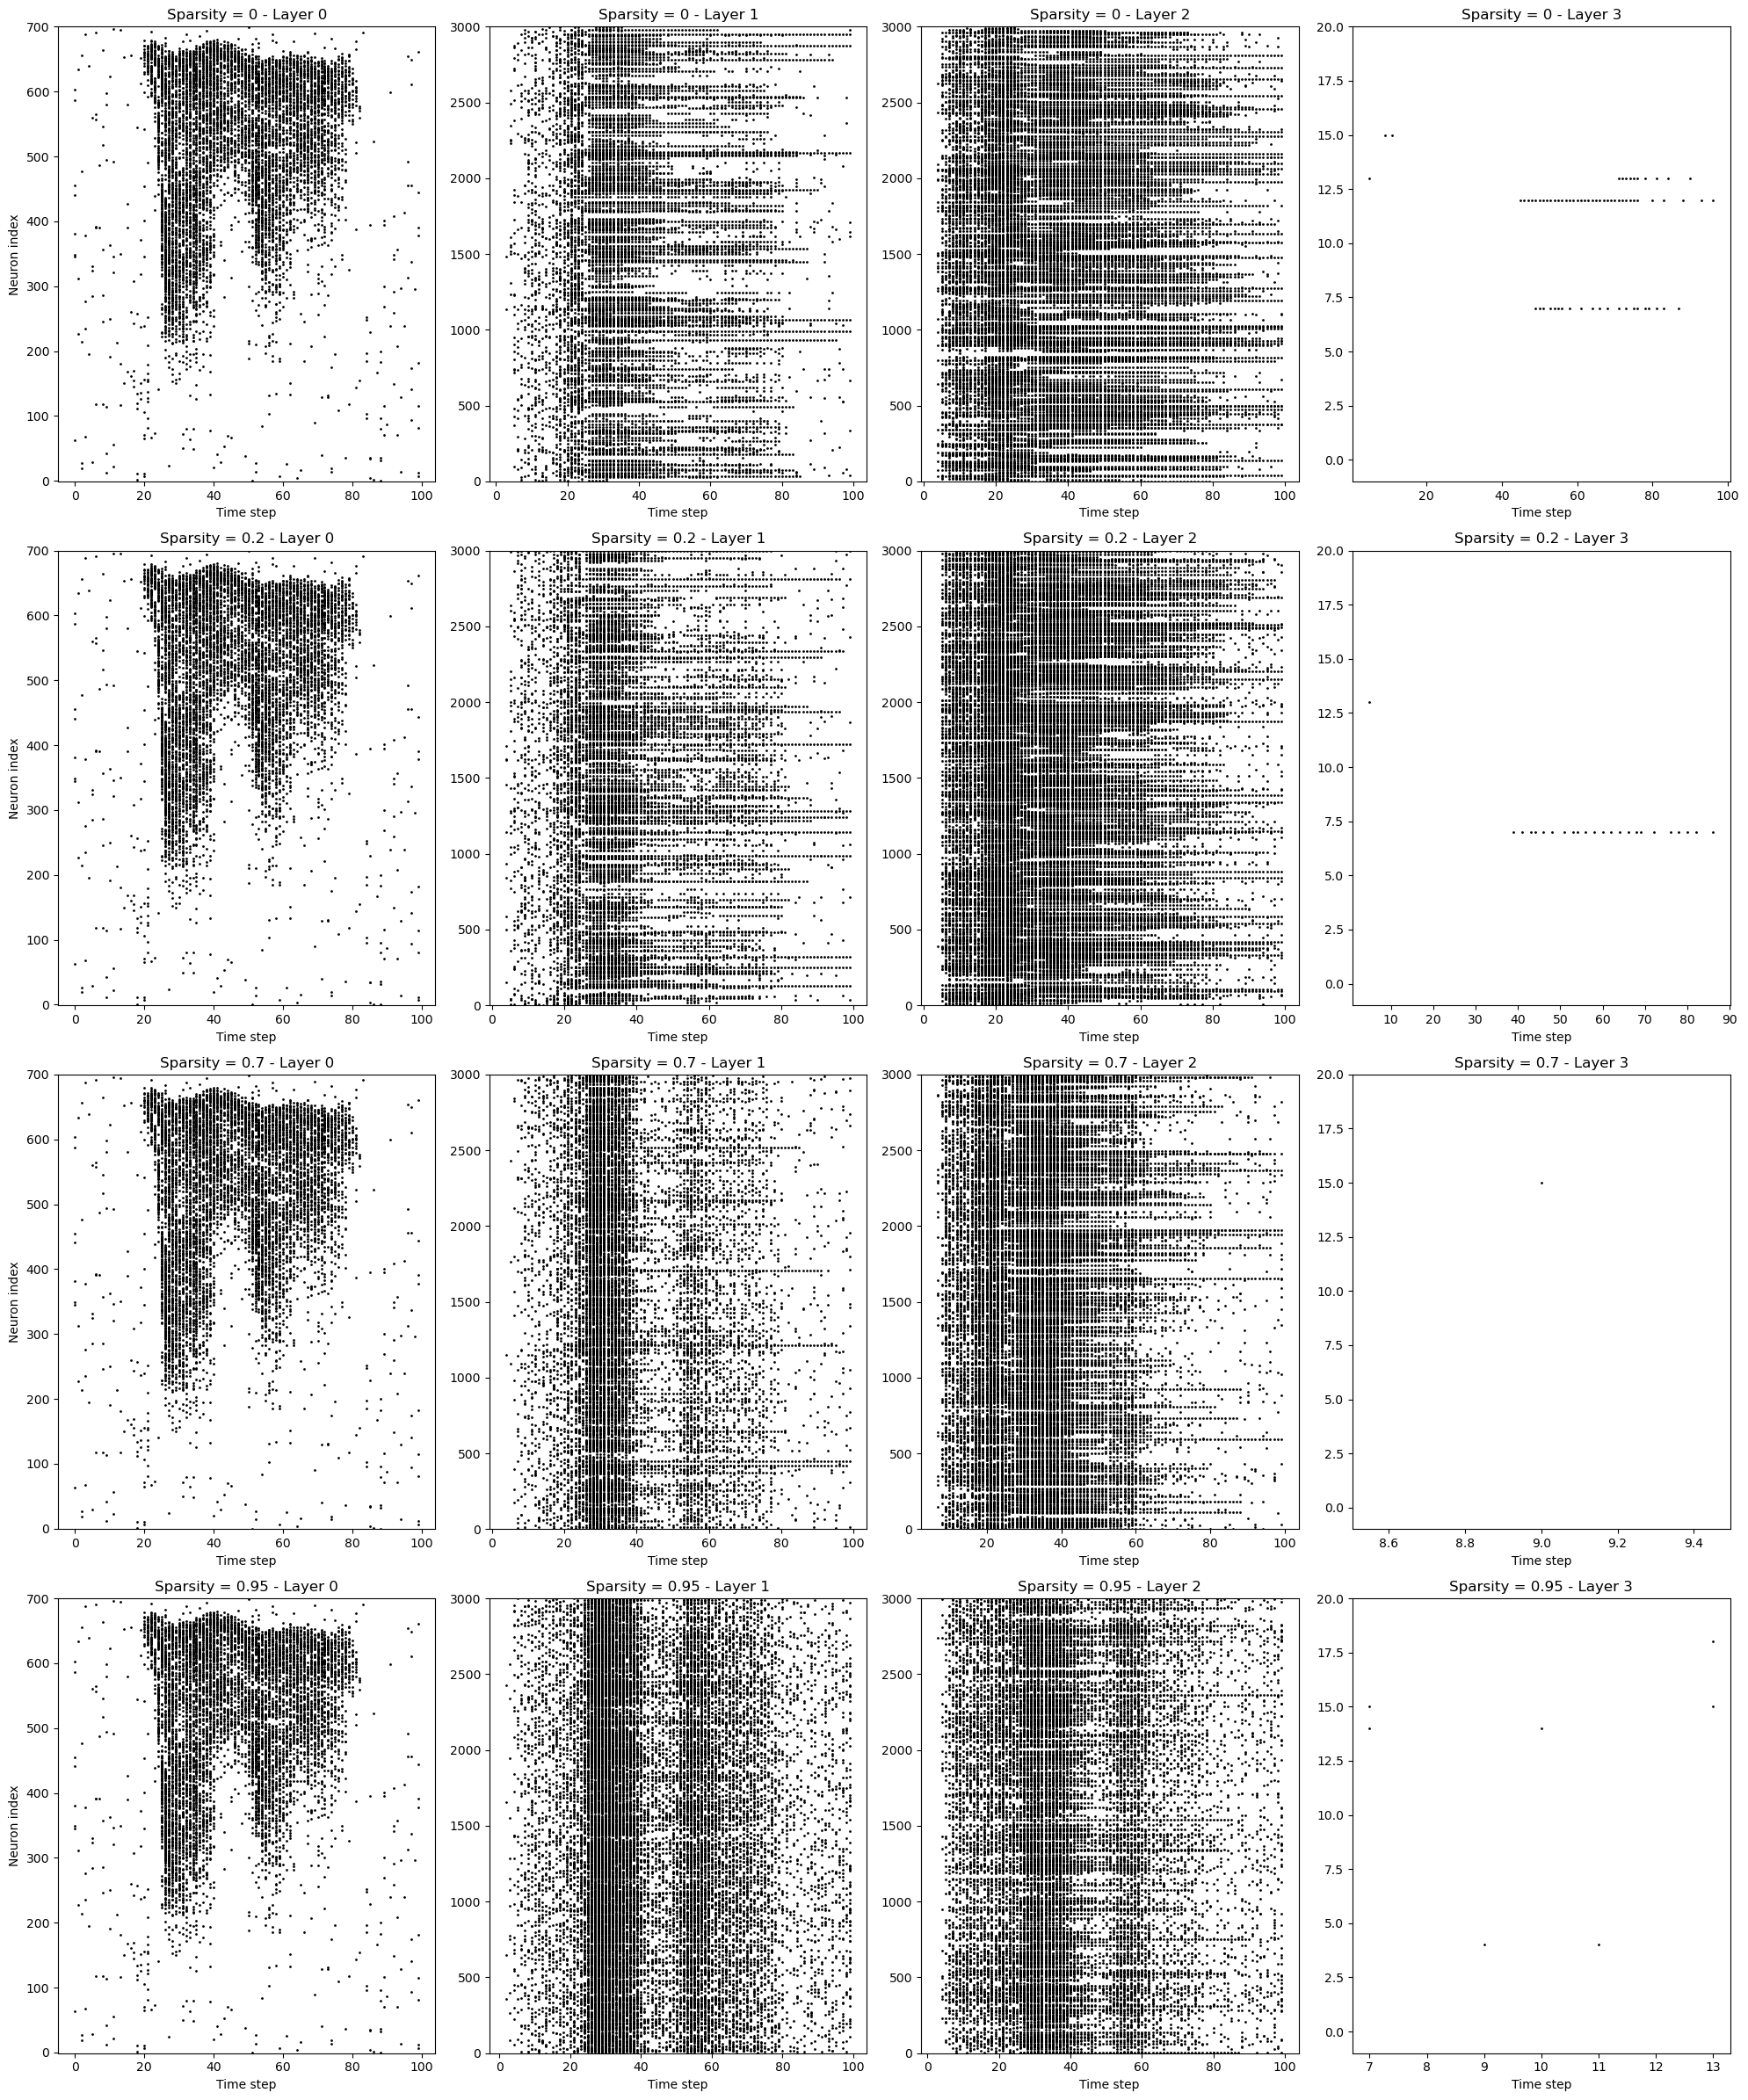

In [7]:
plot_layer_development(models, [f'Sparsity = {sparsity}' for sparsity in sparsities])

In [9]:
from itertools import product

from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from training.train_snn import train_snn

BEST_NUMBER_HIDDEN_LAYER = 2
BEST_NUMBER_HIDDEN_NEURONS = 3000

def create_best_grid_search_model(beta, threshold):
    return ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=BEST_NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=BEST_NUMBER_HIDDEN_LAYER)


NUM_EPOCHS = [2, 4, 10, 15]

if __name__ == '__main__':
    for num_epochs in NUM_EPOCHS:
        model = create_best_grid_search_model(beta=0.99, threshold=1)

        print('epochs = ', num_epochs)

        train_snn(model, 
                            sparsity=0,
                            num_epochs=num_epochs, 
                            save_model=f'./models/experiment_layer_development_investigation/training_epochs_denseness_number_epochs_{num_epochs}', 
                            save_plots=f'./output/experiments_layer_development_investigation/training_epochs_denseness_number_epochs_{num_epochs}', 
                            additional_output_information={
                                'num_hidden_layer': BEST_NUMBER_HIDDEN_LAYER,
                                'num_hidden_neurons': BEST_NUMBER_HIDDEN_NEURONS,
                            },
                            output_file_path=f'./output/experiments_layer_development_investigation/training_epochs_denseness_number_epochs_{num_epochs}.json')
    
    print('DONE')

epochs =  2
Epoch: 0
loss 289.2085011825075
train accuracy 0.47658165767533106
test accuracy 61.130742049469966
Epoch: 1
loss 240.14484729925869
train accuracy 0.7335703776360961
test accuracy 66.56360424028269
epochs =  4
Epoch: 0
loss 289.52910202048815
train accuracy 0.4760912211868563
test accuracy 58.613074204947
Epoch: 1
loss 245.29487924168893
train accuracy 0.7302599313388917
test accuracy 66.1660777385159
Epoch: 2
loss 199.00660585082588
train accuracy 0.8075036782736635
test accuracy 65.54770318021201
Epoch: 3
loss 168.24106088650467
train accuracy 0.863903874448259
test accuracy 68.7720848056537
epochs =  10
Epoch: 0
loss 295.8259434197217
train accuracy 0.4678764100049044
test accuracy 60.07067137809187
Epoch: 1


KeyboardInterrupt: 

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

beta = 0.99
threshold = 1

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for num_epochs in [2, 4, 10, 15]:    
    model = copy.deepcopy(base_net)
    model_path = f'./models/experiment_layer_development_investigation/training_epochs_denseness_number_epochs_{num_epochs}.pth'
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    models.append(model)

plot_layer_development(models, [f'Training Epochs = {num_epochs}' for num_epochs in [2, 4, 10, 15]])

# Accuracy and Time

In [2]:
from glob import glob
import json
import pandas as pd

files = glob('./output/experiments_layer_development_investigation/*.json')

all_dicts = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)
        all_dicts.append(data)

df = pd.DataFrame(all_dicts)
original_df = df.copy()

df["average_training_time_per_epoch"] = df["time"] / df["epochs"]

df = df[(df["beta"] > 0.5) & (df["threshold"] < 3)]

(df.sort_values("test_accuracy"))[["epochs", "test_accuracy", "sparsity", "beta", "threshold", "average_training_time_per_epoch"]]

epochs  test_accuracy  sparsity  beta  threshold  \
4        6      38.515901      0.95  0.99        0.7   
6        8      39.620141      0.95  0.99        1.0   
10       7      42.005300      0.70  0.99        1.0   
14      14      59.363958      0.70  0.99        0.7   
9       56      61.307420      0.95  0.80        1.0   
3       12      64.796820      0.00  0.99        0.7   
13      36      65.106007      0.70  0.80        1.0   
17      24      67.314488      0.20  0.80        1.0   
12       8      67.932862      0.20  0.99        0.7   
15      10      70.229682      0.00  0.99        1.0   
7       21      70.362191      0.70  0.80        0.7   
19      25      70.715548      0.95  0.80        0.7   
5       15      70.892226      0.00  0.80        1.0   
8       14      71.643110      0.00  0.80        0.7   
18      22      71.952297      0.20  0.80        0.7   
1        8      72.217314      0.20  0.99        1.0   

    average_training_time_per_epoch  
4                        822.925837  
6                        763.265529  
10                       771.712926  
14                       738.234035  
9                        710.448288  
3                        431.855382  
13                       728.505273  
17                       742.817294  
12                       770.564634  
15                       482.918441  
7                        453.213798  
19                       451.690889  
5                        413.702296  
8                        455.781714  
18                       728.018830  
1                        774.047120

# Layer Development

In [3]:
import torch
from util.get_device import get_device
from torch.utils.data import DataLoader
from tonic import datasets, transforms
from constants import TIME_STEPS

selection_index = 2
device = get_device()

frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]


/home/mark/anaconda3/envs/whk-snn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


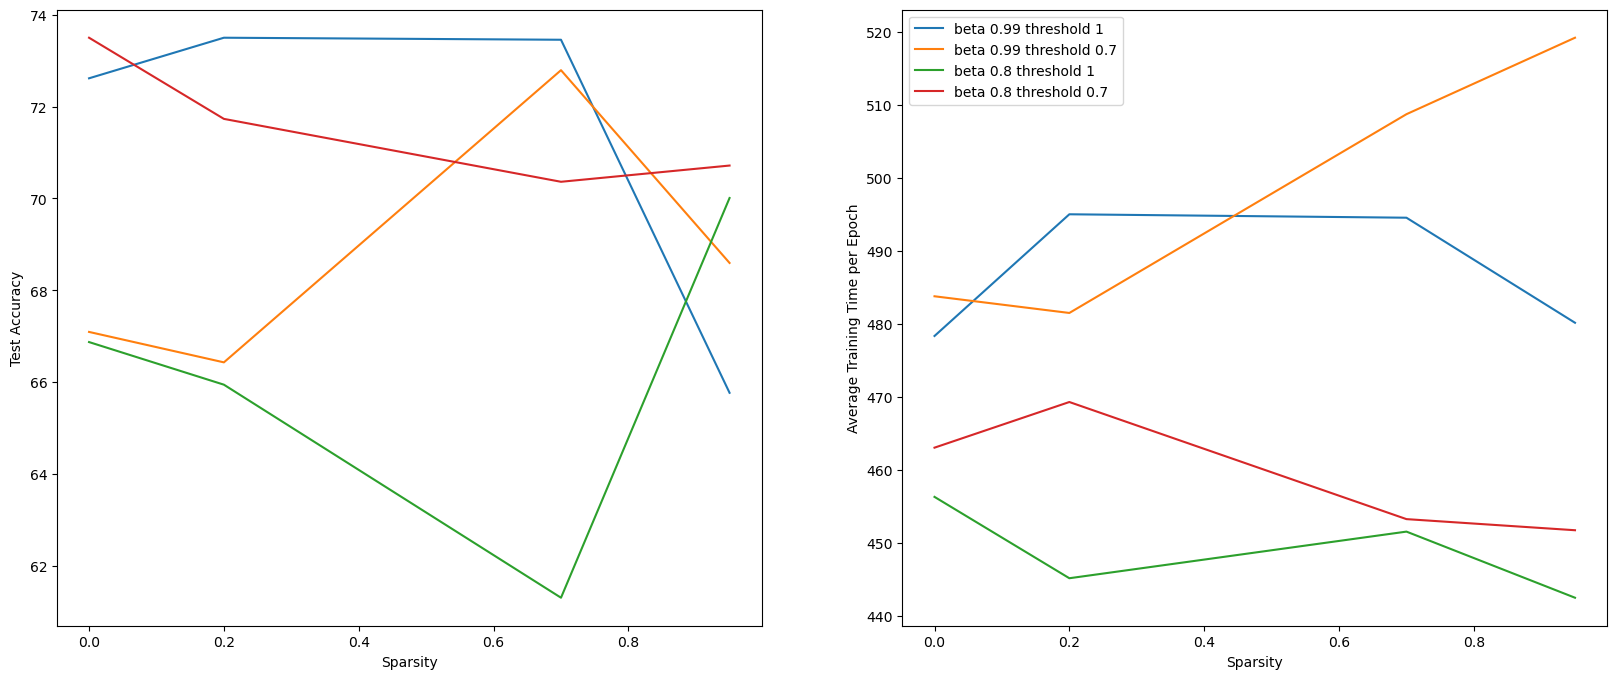

In [4]:
import matplotlib.pyplot as plt

beta_099_threshold_1 = df[(df["beta"] == 0.99) & (df["threshold"] == 1)].sort_values("sparsity")
sparsity_beta_099_threshold_1 = beta_099_threshold_1["sparsity"].to_numpy()

test_accuracy_beta_099_threshold_1 = beta_099_threshold_1["test_accuracy"].to_numpy()
average_training_time_per_epoch_beta_099_threshold_1 = beta_099_threshold_1["average_training_time_per_epoch"].to_numpy()

beta_099_threshold_07 = df[(df["beta"] == 0.99) & (df["threshold"] == 0.7)].sort_values("sparsity")
sparsity_beta_099_threshold_07 = beta_099_threshold_07["sparsity"].to_numpy()

test_accuracy_beta_099_threshold_07 = beta_099_threshold_07["test_accuracy"].to_numpy()
average_training_time_per_epoch_beta_099_threshold_07 = beta_099_threshold_07["average_training_time_per_epoch"].to_numpy()

beta_08_threshold_1 = df[(df["beta"] == 0.8) & (df["threshold"] == 1)].sort_values("sparsity")
sparsity_beta_08_threshold_1 = beta_08_threshold_1["sparsity"].to_numpy()

test_accuracy_beta_08_threshold_1 = beta_08_threshold_1["test_accuracy"].to_numpy()
average_training_time_per_epoch_beta_08_threshold_1 = beta_08_threshold_1["average_training_time_per_epoch"].to_numpy()

beta_08_threshold_07 = df[(df["beta"] == 0.8) & (df["threshold"] == 0.7)].sort_values("sparsity")
sparsity_beta_08_threshold_07 = beta_08_threshold_07["sparsity"].to_numpy()

test_accuracy_beta_08_threshold_07 = beta_08_threshold_07["test_accuracy"].to_numpy()
average_training_time_per_epoch_beta_08_threshold_07 = beta_08_threshold_07["average_training_time_per_epoch"].to_numpy()

fig, axs = plt.subplots(ncols = 2, nrows=1, figsize=(20, 8))

axs[0].plot(sparsity_beta_099_threshold_1, test_accuracy_beta_099_threshold_1, label="beta 0.99 threshold 1")
axs[0].plot(sparsity_beta_099_threshold_07, test_accuracy_beta_099_threshold_07, label="beta 0.99 threshold 0.7")
axs[0].plot(sparsity_beta_08_threshold_1, test_accuracy_beta_08_threshold_1, label="beta 0.8  threshold 1")
axs[0].plot(sparsity_beta_08_threshold_07, test_accuracy_beta_08_threshold_07, label="beta 0.8  threshold 0.7")
axs[0].set_ylabel("Test Accuracy")
axs[0].set_xlabel("Sparsity")

axs[1].plot(sparsity_beta_099_threshold_1, average_training_time_per_epoch_beta_099_threshold_1, label="beta 0.99 threshold 1")
axs[1].plot(sparsity_beta_099_threshold_07, average_training_time_per_epoch_beta_099_threshold_07, label="beta 0.99 threshold 0.7")
axs[1].plot(sparsity_beta_08_threshold_1, average_training_time_per_epoch_beta_08_threshold_1, label="beta 0.8 threshold 1")
axs[1].plot(sparsity_beta_08_threshold_1, average_training_time_per_epoch_beta_08_threshold_07, label="beta 0.8 threshold 0.7")
axs[1].set_ylabel("Average Training Time per Epoch")
axs[1].set_xlabel("Sparsity")

plt.legend()
plt.show()

# Findings

- beta = 0.8 seems to lead to lower training time
- beta = 0.8 seems to increase the test accuracy at higher sparsity levels

In [5]:
selection_index = 2
device = get_device()

frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]


./models/experiment_layer_development_investigation/best_grid_search_sparsity_0_beta_0.99_threshold_1.pth
sparsity: 0.0 | observed zero weights = 0.00
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.2_beta_0.99_threshold_1.pth
sparsity: 0.2 | observed zero weights = 0.00
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.7_beta_0.99_threshold_1.pth
sparsity: 0.7 | observed zero weights = 0.00
./models/experiment_layer_development_investigation/best_grid_search_sparsity_0.95_beta_0.99_threshold_1.pth
sparsity: 0.95 | observed zero weights = 0.10


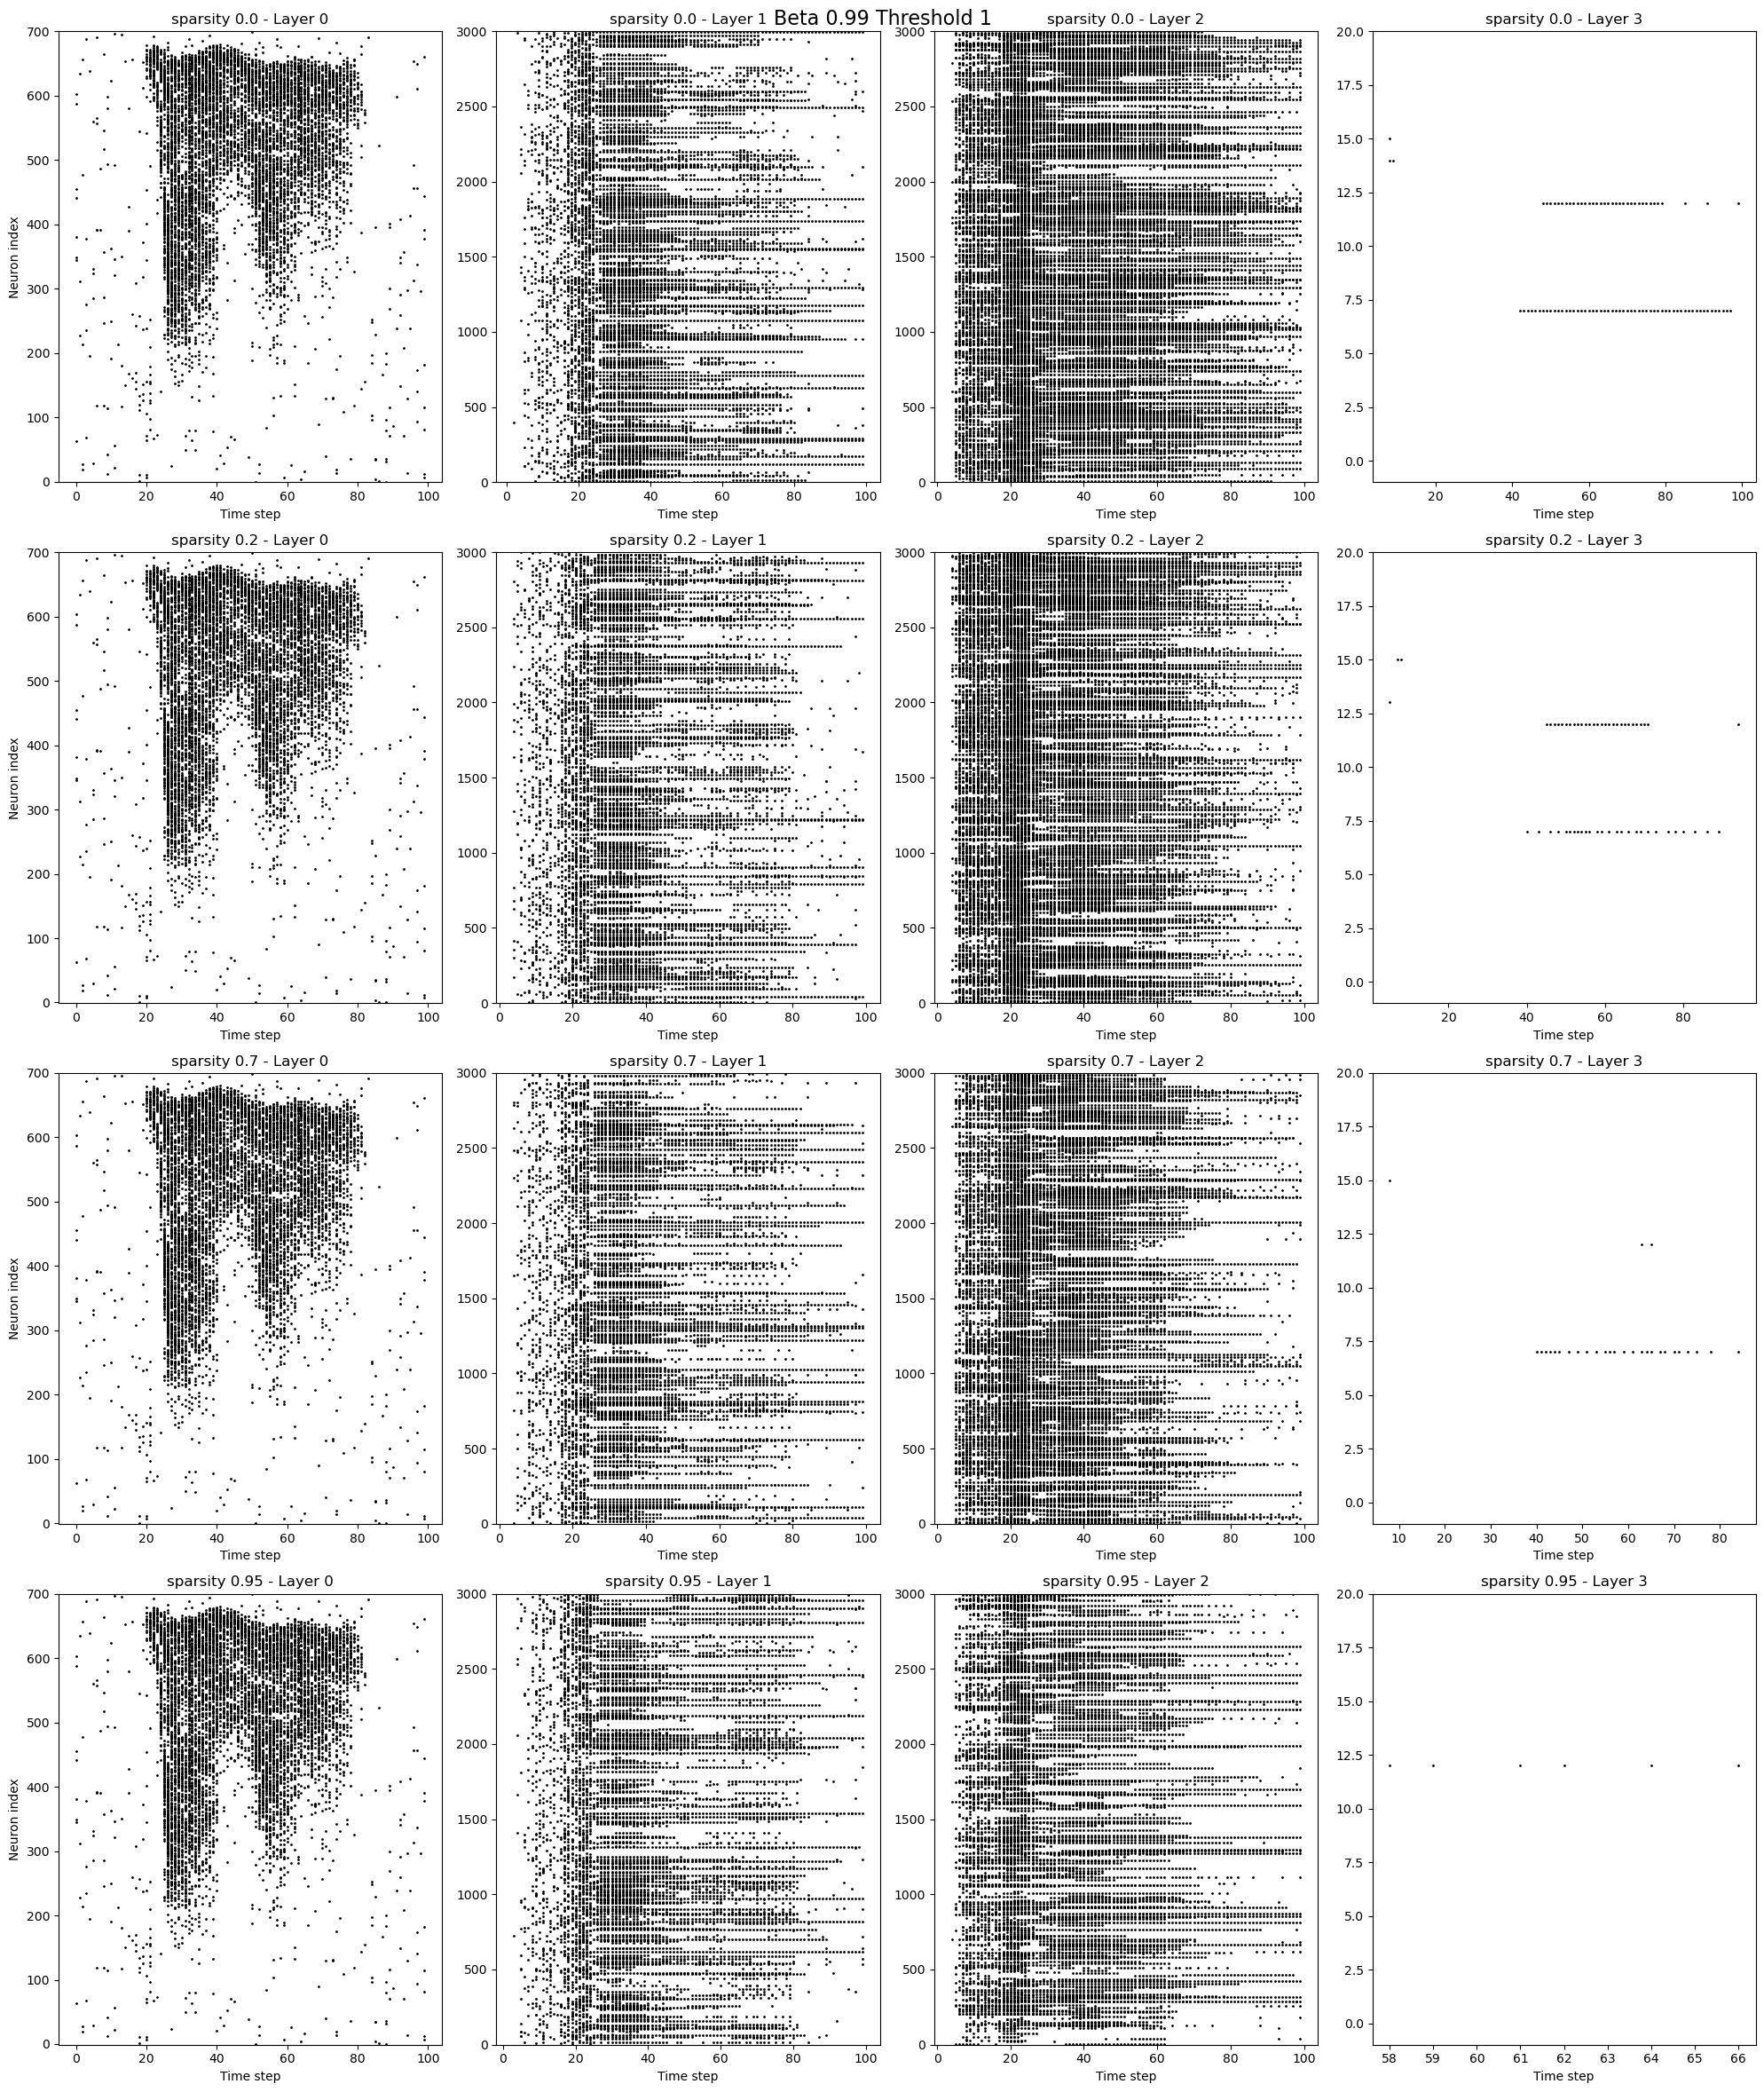

In [8]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from util.plot_layer_development import plot_layer_development

import copy


def count_zero_weights(model):
    zero_count = 0
    total_params = 0
    for param in model.parameters():
        if param.requires_grad:
            zero_count += torch.sum(param == 0).item()
            total_params += param.numel()
    return zero_count, total_params

BEST_NUMBER_HIDDEN_NEURONS = 3000
BEST_NUMBER_HIDDEN_LAYER = 2

nets = []

for sparsity in beta_099_threshold_1["sparsity"]:
    beta = 0.99
    threshold = 1
    configured_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=BEST_NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=BEST_NUMBER_HIDDEN_LAYER)
    
    model = copy.deepcopy(configured_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))
    zero_weights, total_count = count_zero_weights(model)
    print(f"sparsity: {sparsity} | observed zero weights = {(zero_weights / total_count):.2f}")
    nets.append((beta, threshold, sparsity, model))


models = [model for _,_,_, model in nets]

row_labels = [f'sparsity {sparsity}' for _, _, sparsity, _ in nets]

plot_layer_development(models, data, selection_index, row_labels, "Beta 0.99 Threshold 1")

In [7]:
beta_099_threshold_1

epochs  training_accuracy  test_accuracy         time  num_hidden_layer  \
15      10           0.960152      70.053004  5234.016630                 2   
1       16           0.980383      73.056537  8881.551641                 2   
10       9           0.948259      71.731449  5189.395819                 2   
6       10           0.868195      65.326855  4784.253639                 2   

    num_hidden_neurons  sparsity  beta  threshold  \
15                3000      0.00  0.99        1.0   
1                 3000      0.20  0.99        1.0   
10                3000      0.70  0.99        1.0   
6                 3000      0.95  0.99        1.0   

    average_training_time_per_epoch  
15                       523.401663  
1                        555.096978  
10                       576.599535  
6                        478.425364

In [ ]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from util.plot_layer_development import plot_layer_development

BEST_NUMBER_HIDDEN_NEURONS = 3000
BEST_NUMBER_HIDDEN_LAYER = 2

nets = []

for sparsity in beta_08_threshold_1["sparsity"]:
    beta = 0.8
    threshold = 1
    configured_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=BEST_NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=BEST_NUMBER_HIDDEN_LAYER)
    
    configured_net.load_state_dict(torch.load(build_model_path(sparsity, beta, threshold)))
    nets.append((beta, threshold, sparsity, configured_net))


models = [model for _,_,_, model in nets]

row_labels = [f'sparsity {sparsity}' for _, _, sparsity, _ in nets]

plot_layer_development(models, data, selection_index, row_labels, "Beta 0.99 Threshold 1")

TypeError: plot_layer_development() got an unexpected keyword argument 'figsize'

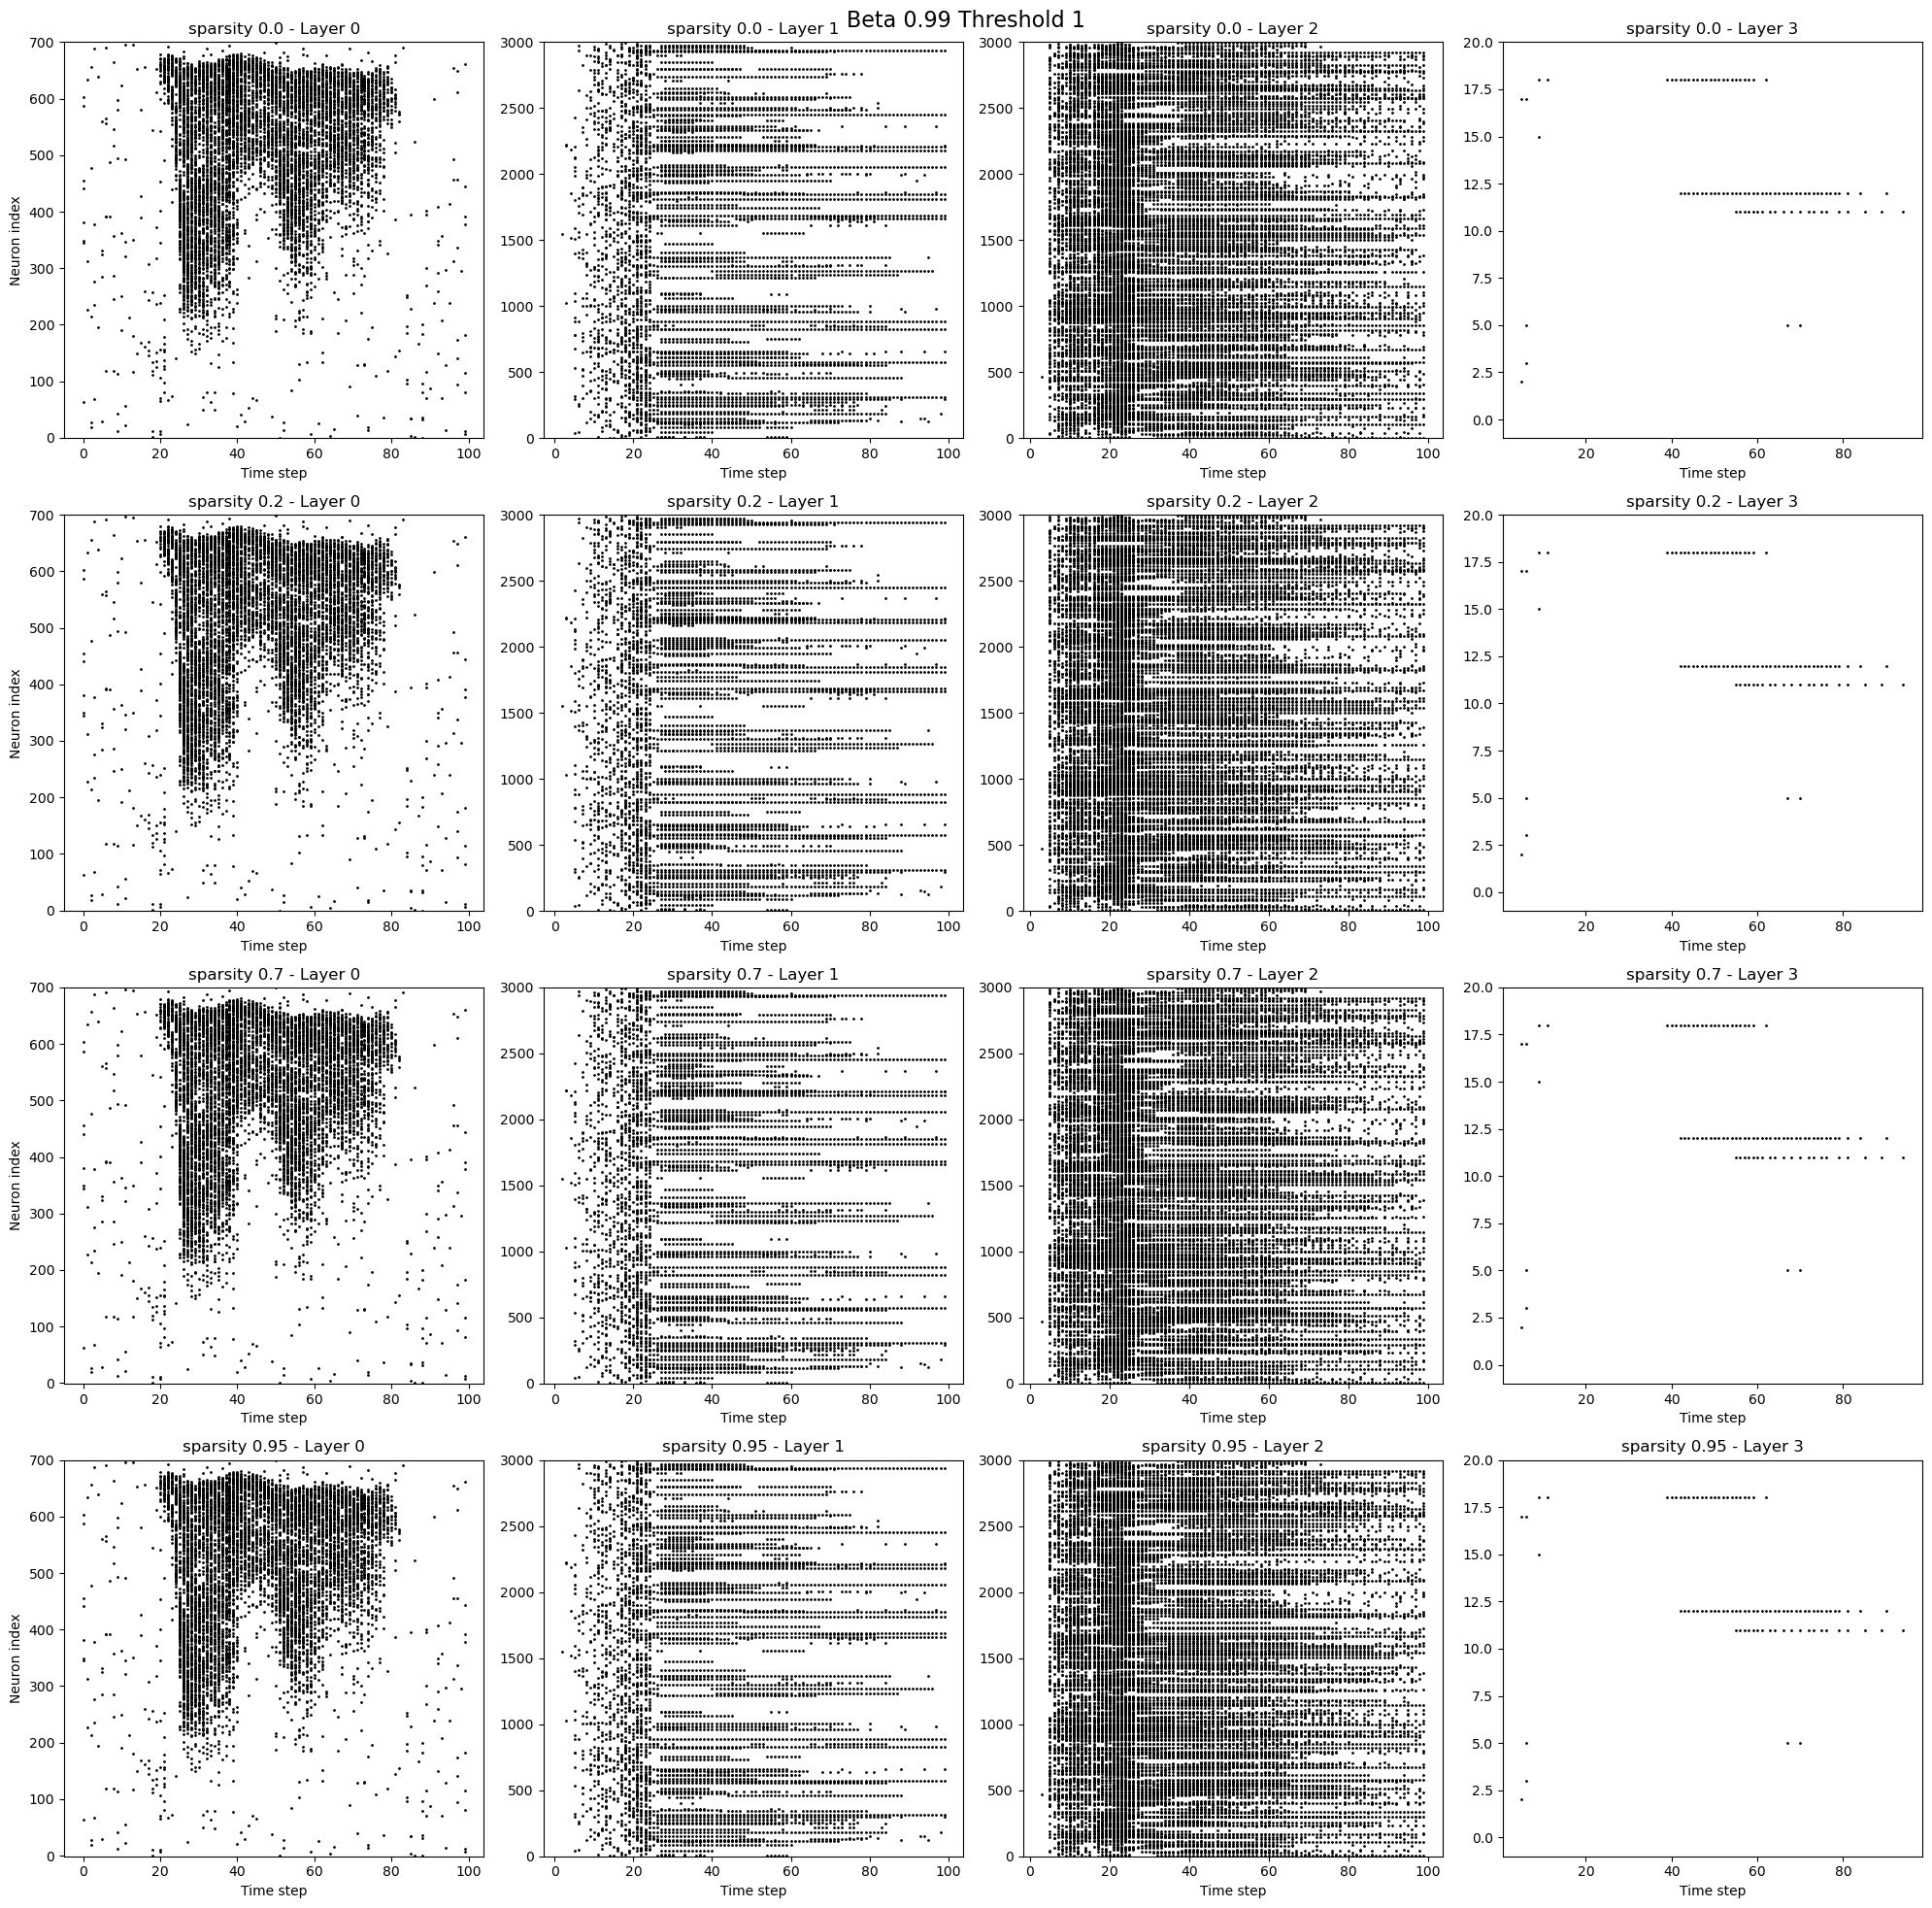

In [ ]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from util.plot_layer_development import plot_layer_development

BEST_NUMBER_HIDDEN_NEURONS = 3000
BEST_NUMBER_HIDDEN_LAYER = 2

nets = []

for sparsity in beta_099_threshold_07["sparsity"]:
    beta = 0.99
    threshold = 0.7
    configured_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=BEST_NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=BEST_NUMBER_HIDDEN_LAYER)
    
    configured_net.load_state_dict(torch.load(build_model_path(sparsity, beta, threshold)))
    nets.append((beta, threshold, sparsity, configured_net))


models = [model for _,_,_, model in nets]

row_labels = [f'sparsity {sparsity}' for _, _, sparsity, _ in nets]

plot_layer_development(models, data, selection_index, row_labels, "Beta 0.99 Threshold 1")

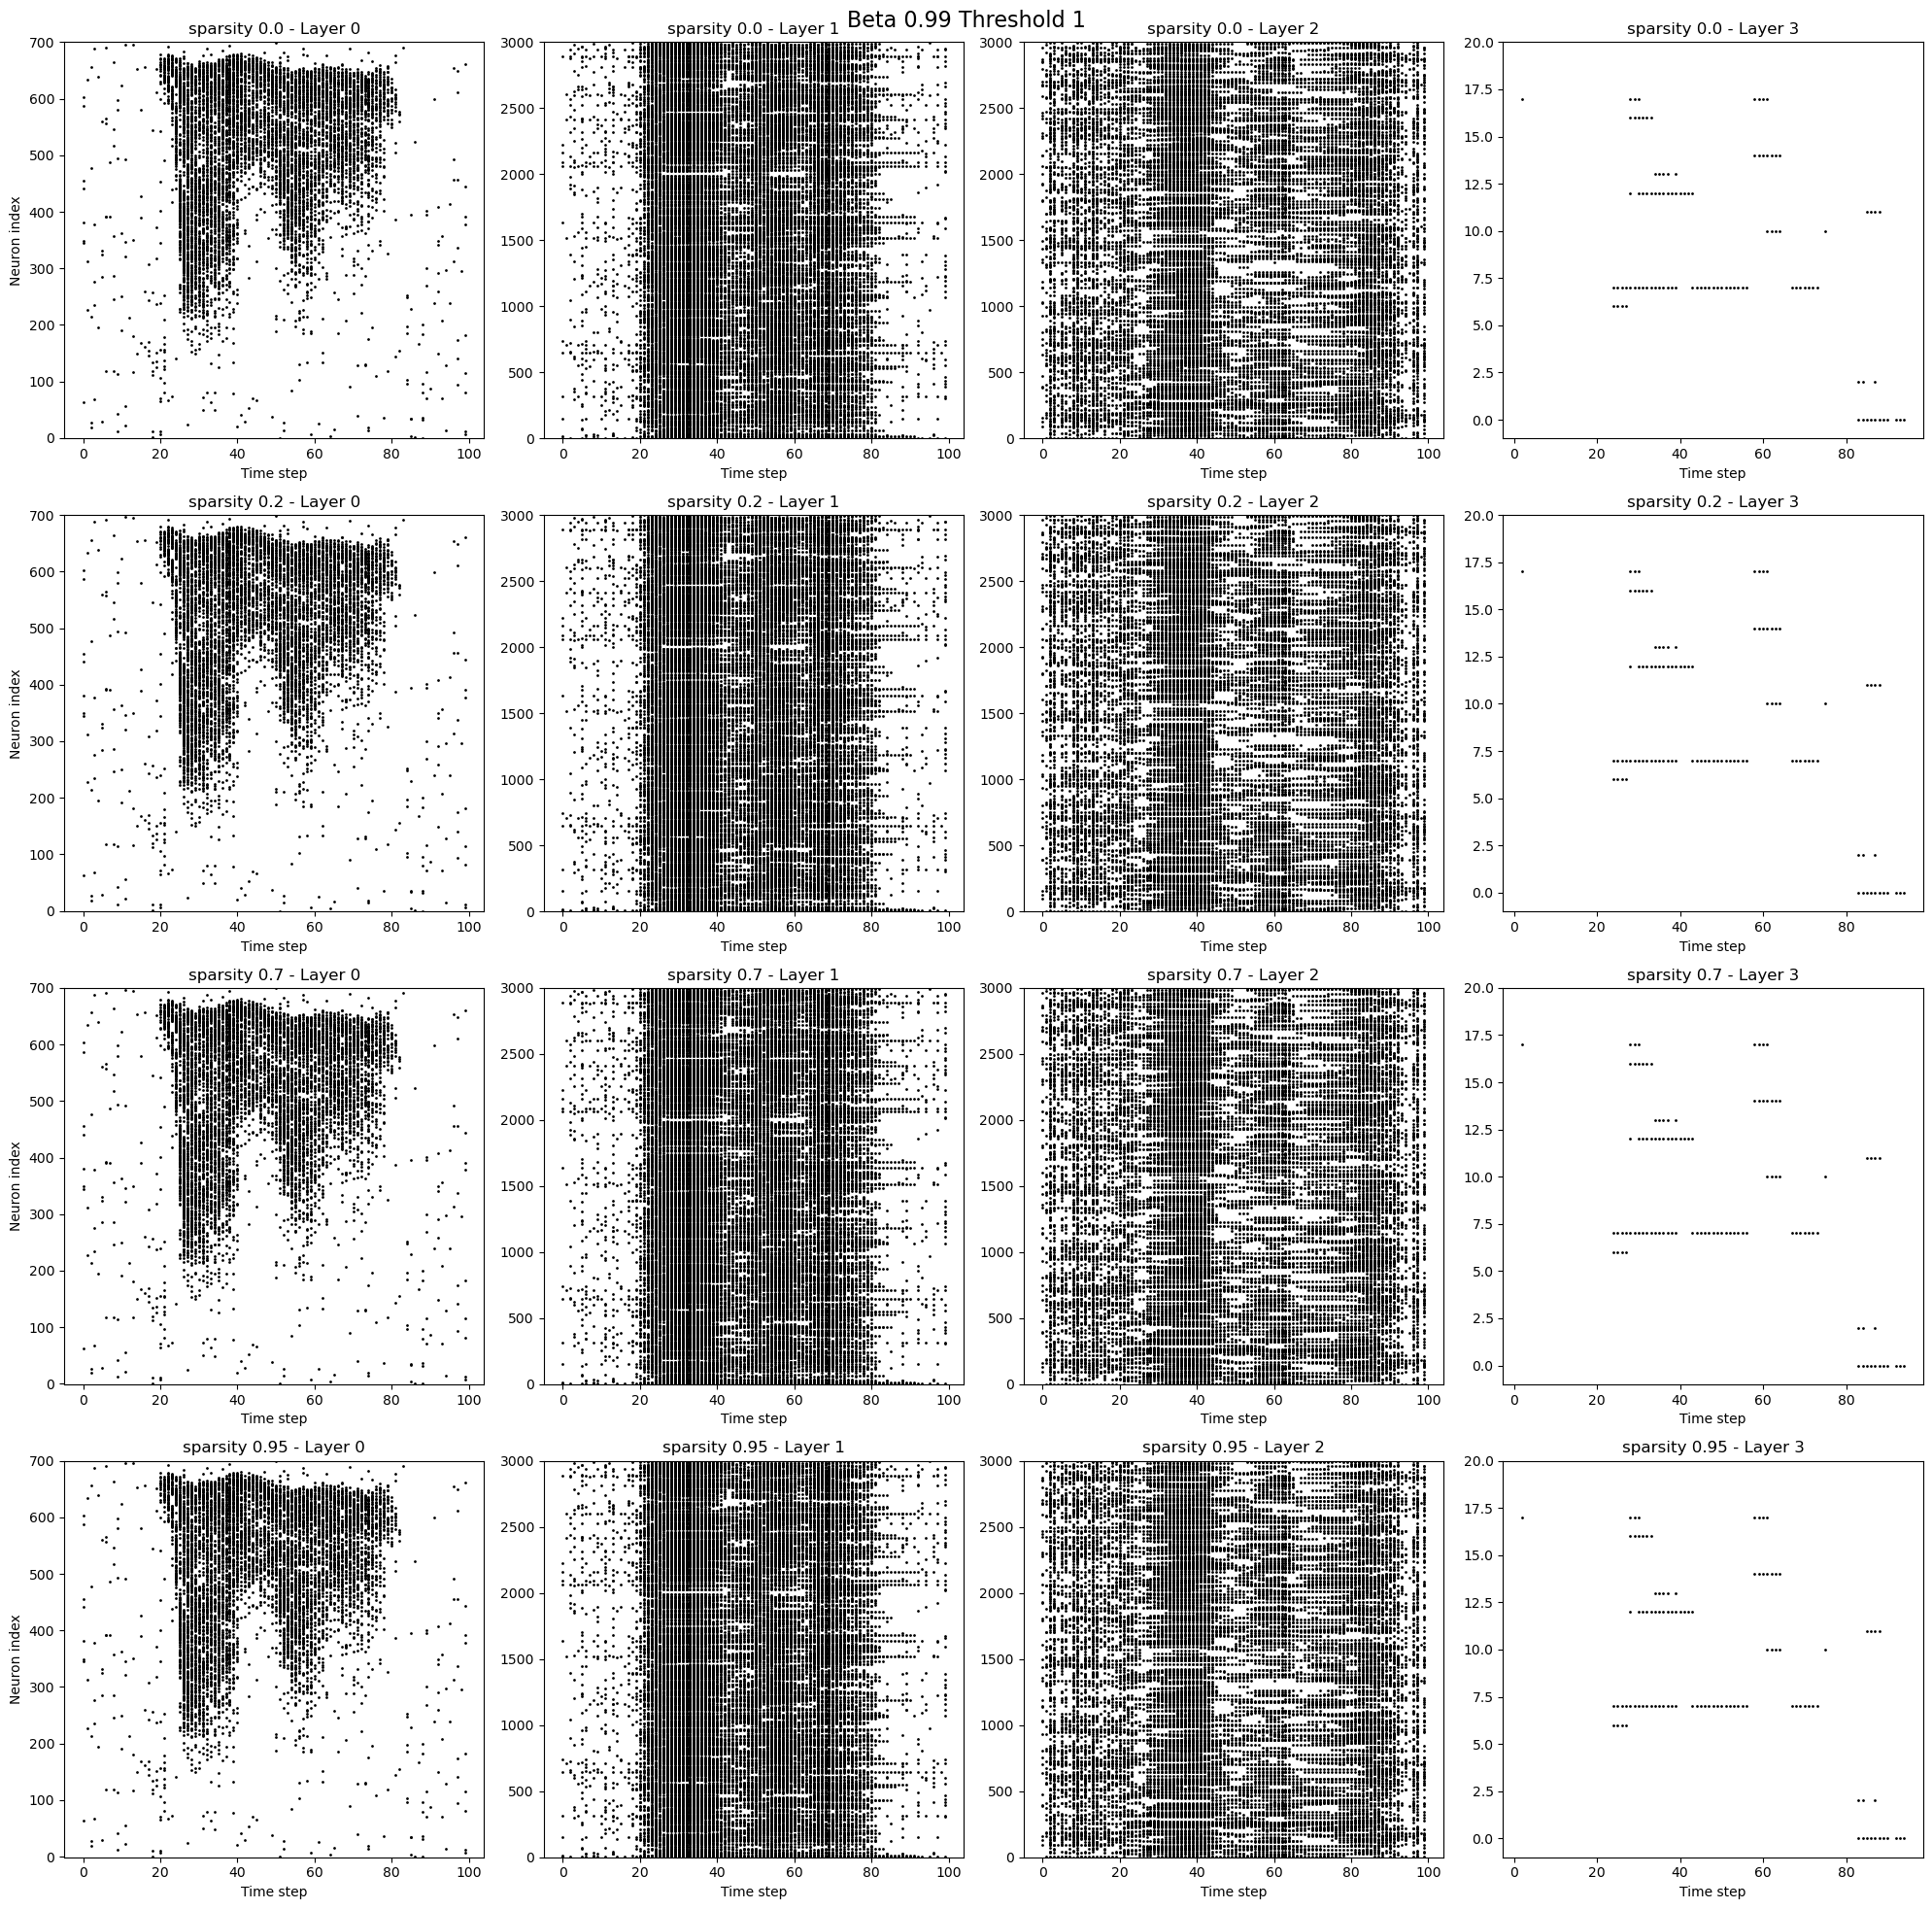

In [ ]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from util.plot_layer_development import plot_layer_development

BEST_NUMBER_HIDDEN_NEURONS = 3000
BEST_NUMBER_HIDDEN_LAYER = 2

nets = []

for sparsity in beta_08_threshold_07["sparsity"]:
    beta = 0.8
    threshold = 0.7
    configured_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=BEST_NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=BEST_NUMBER_HIDDEN_LAYER)
    
    configured_net.load_state_dict(torch.load(build_model_path(sparsity, beta, threshold)))
    nets.append((beta, threshold, sparsity, configured_net))


models = [model for _,_,_, model in nets]

row_labels = [f'sparsity {sparsity}' for _, _, sparsity, _ in nets]

plot_layer_development(models, data, selection_index, row_labels, "Beta 0.99 Threshold 1")

In [ ]:
beta_05_threshold_3 = original_df[(original_df["beta"] == 0.5) | (original_df["threshold"] == 3)]

beta_05_threshold_3

epochs  training_accuracy  test_accuracy          time  num_hidden_layer  \
2        6           0.455248      39.796820   5581.846544                 2   
11      18           0.970329      56.227915   8095.335637                 2   
16      25           0.874571      57.906360  11138.702326                 2   
20       8           0.309465      22.482332   3850.559719                 2   
21      20           0.961869      55.256184   8956.519206                 2   

    num_hidden_neurons  sparsity  beta  threshold  
2                 3000       0.0  0.99        3.0  
11                3000       0.0  0.50        0.7  
16                3000       0.0  0.80        3.0  
20                3000       0.0  0.50        3.0  
21                3000       0.0  0.50        1.0

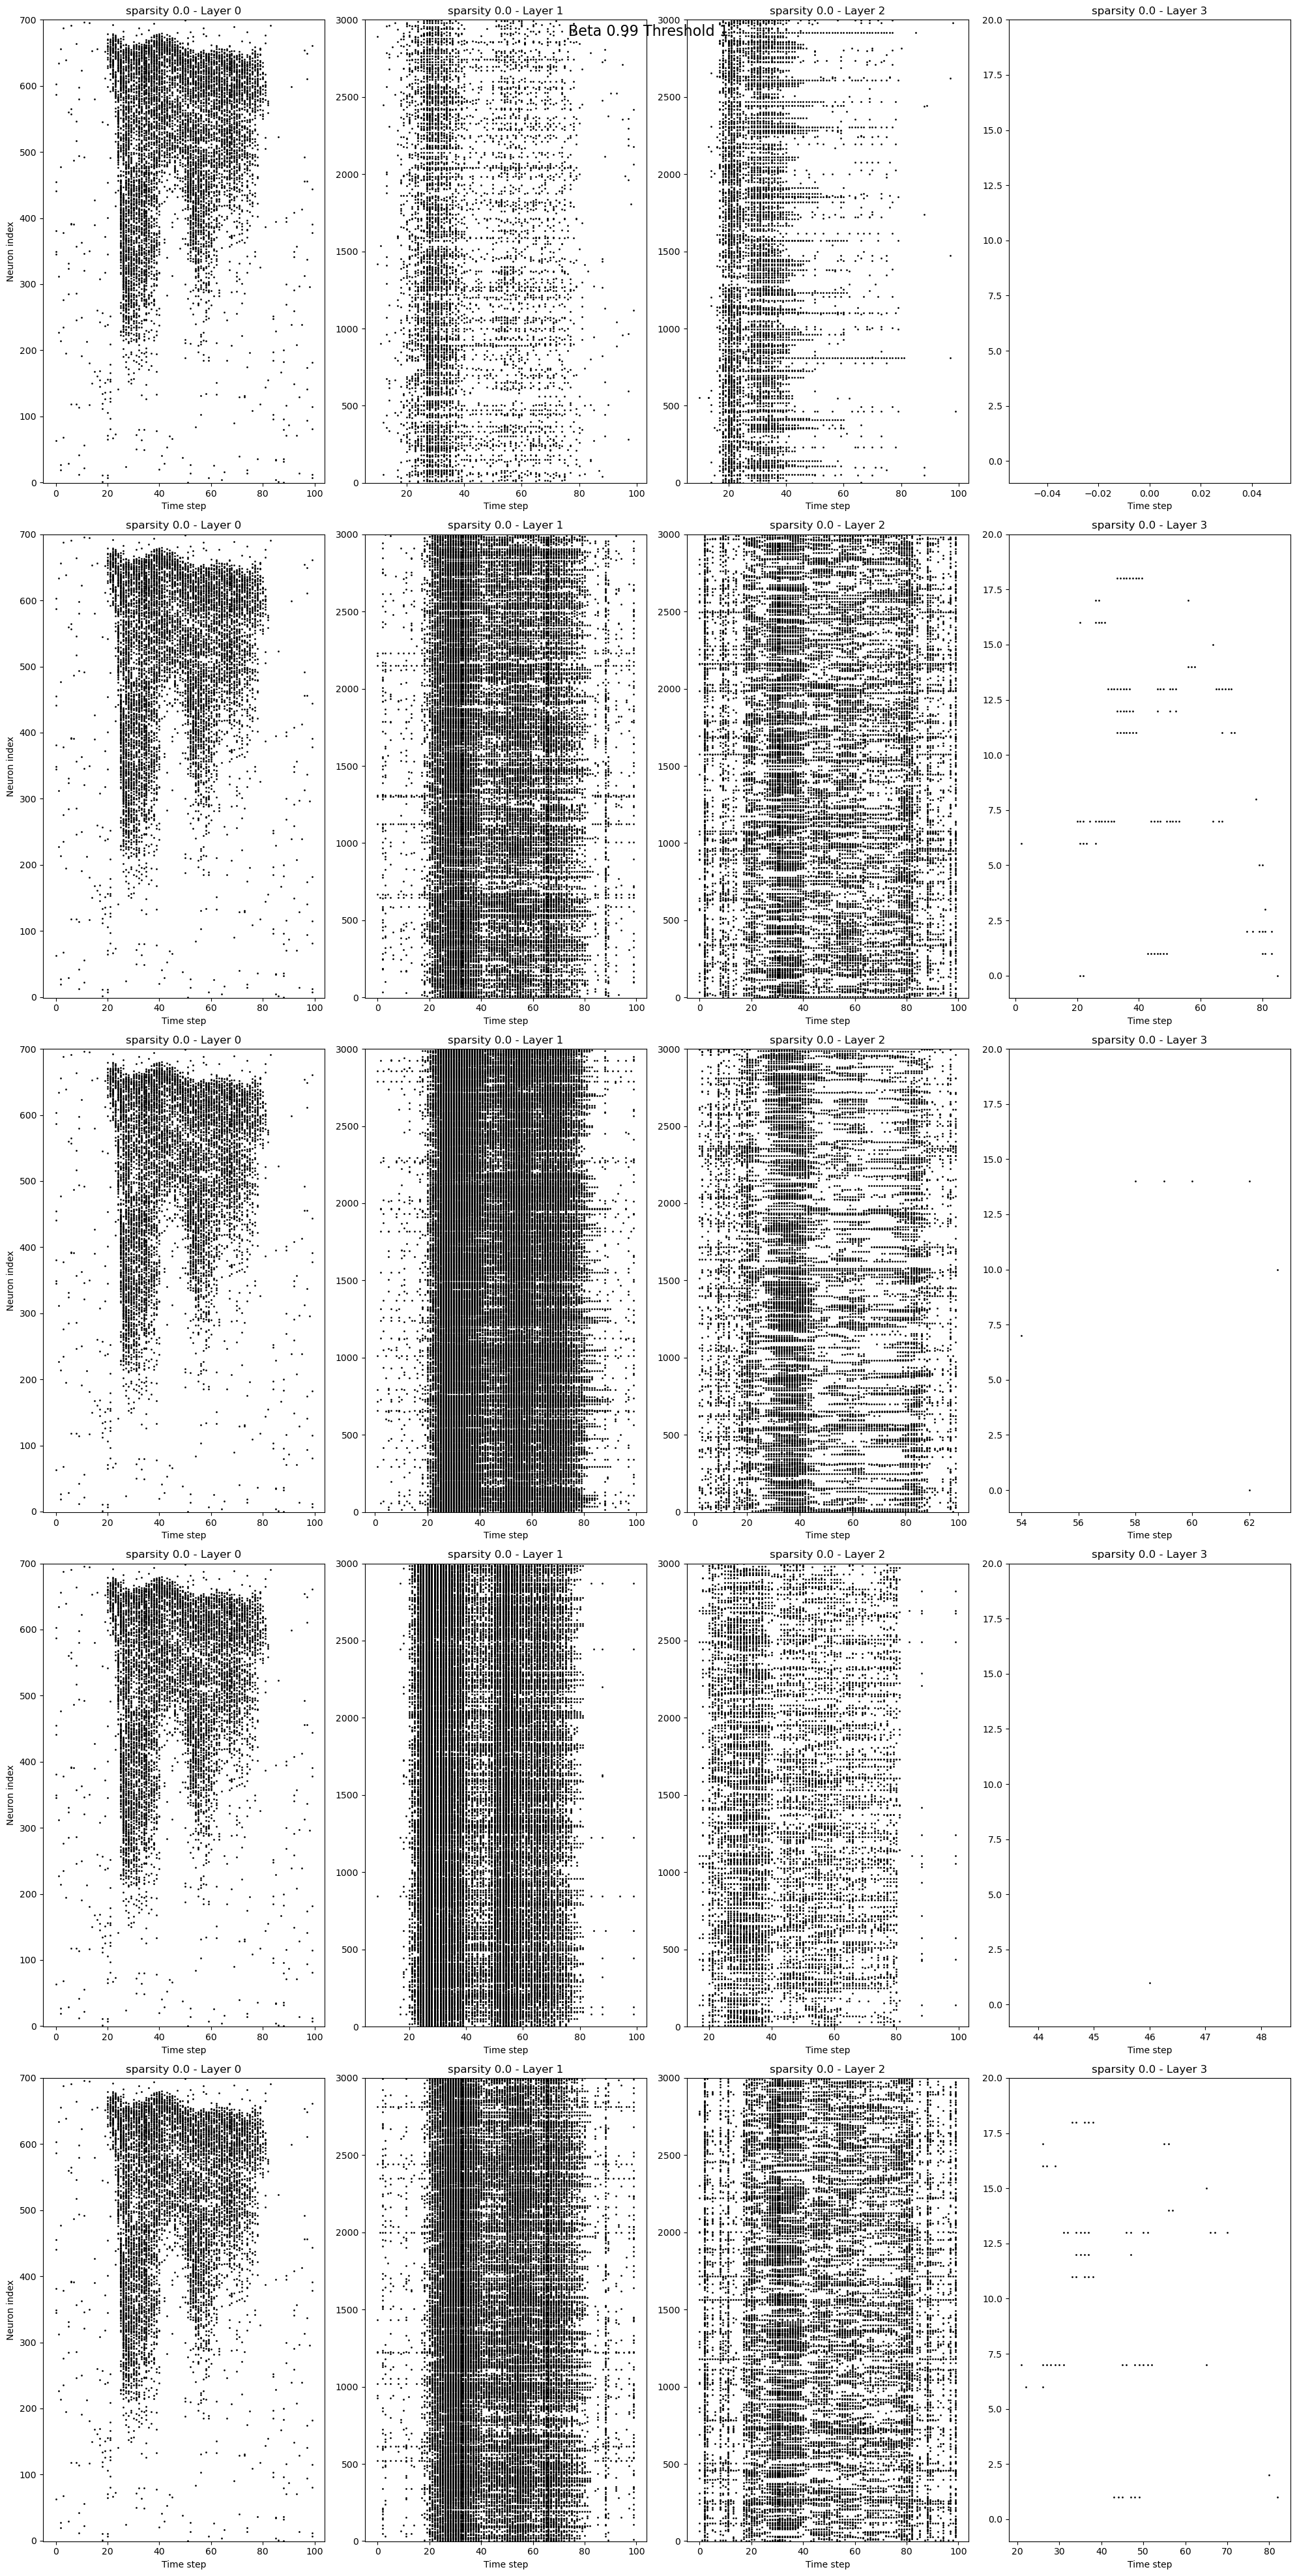

In [ ]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from util.plot_layer_development import plot_layer_development

BEST_NUMBER_HIDDEN_NEURONS = 3000
BEST_NUMBER_HIDDEN_LAYER = 2

nets = []

for sparsity, beta, threshold in beta_05_threshold_3[["sparsity", "beta", "threshold"]].to_numpy():
    configured_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=BEST_NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=BEST_NUMBER_HIDDEN_LAYER)
    
    configured_net.load_state_dict(torch.load(build_model_path(sparsity, beta, threshold)))
    nets.append((beta, threshold, sparsity, configured_net))


models = [model for _,_,_, model in nets]

row_labels = [f'sparsity {sparsity}' for _, _, sparsity, _ in nets]

plot_layer_development(models, data, selection_index, row_labels, "Beta 0.99 Threshold 1")

In [ ]:
from util.plot_layer_development import plot_layer_development

models = [
    atan_model,
    spike_rate_escape_model
]

plot_layer_development(models, data, selection_index, ["ATan", "Spike Rate Escape"], "Different Surrogates", figsize=(20, 12))

NameError: name 'atan_model' is not defined

In [ ]:
def get_spk_matrices(data, model, selection_index):
    spk_recs, _ = model(data)

    output_spk_rec = spk_recs[-1][:, selection_index, :]
    hidden_spk_rec = [hidden_spk_rec[:, selection_index, :].detach() for hidden_spk_rec in spk_recs[:-1]]

    return [x_selected, *hidden_spk_rec, output_spk_rec.detach()]

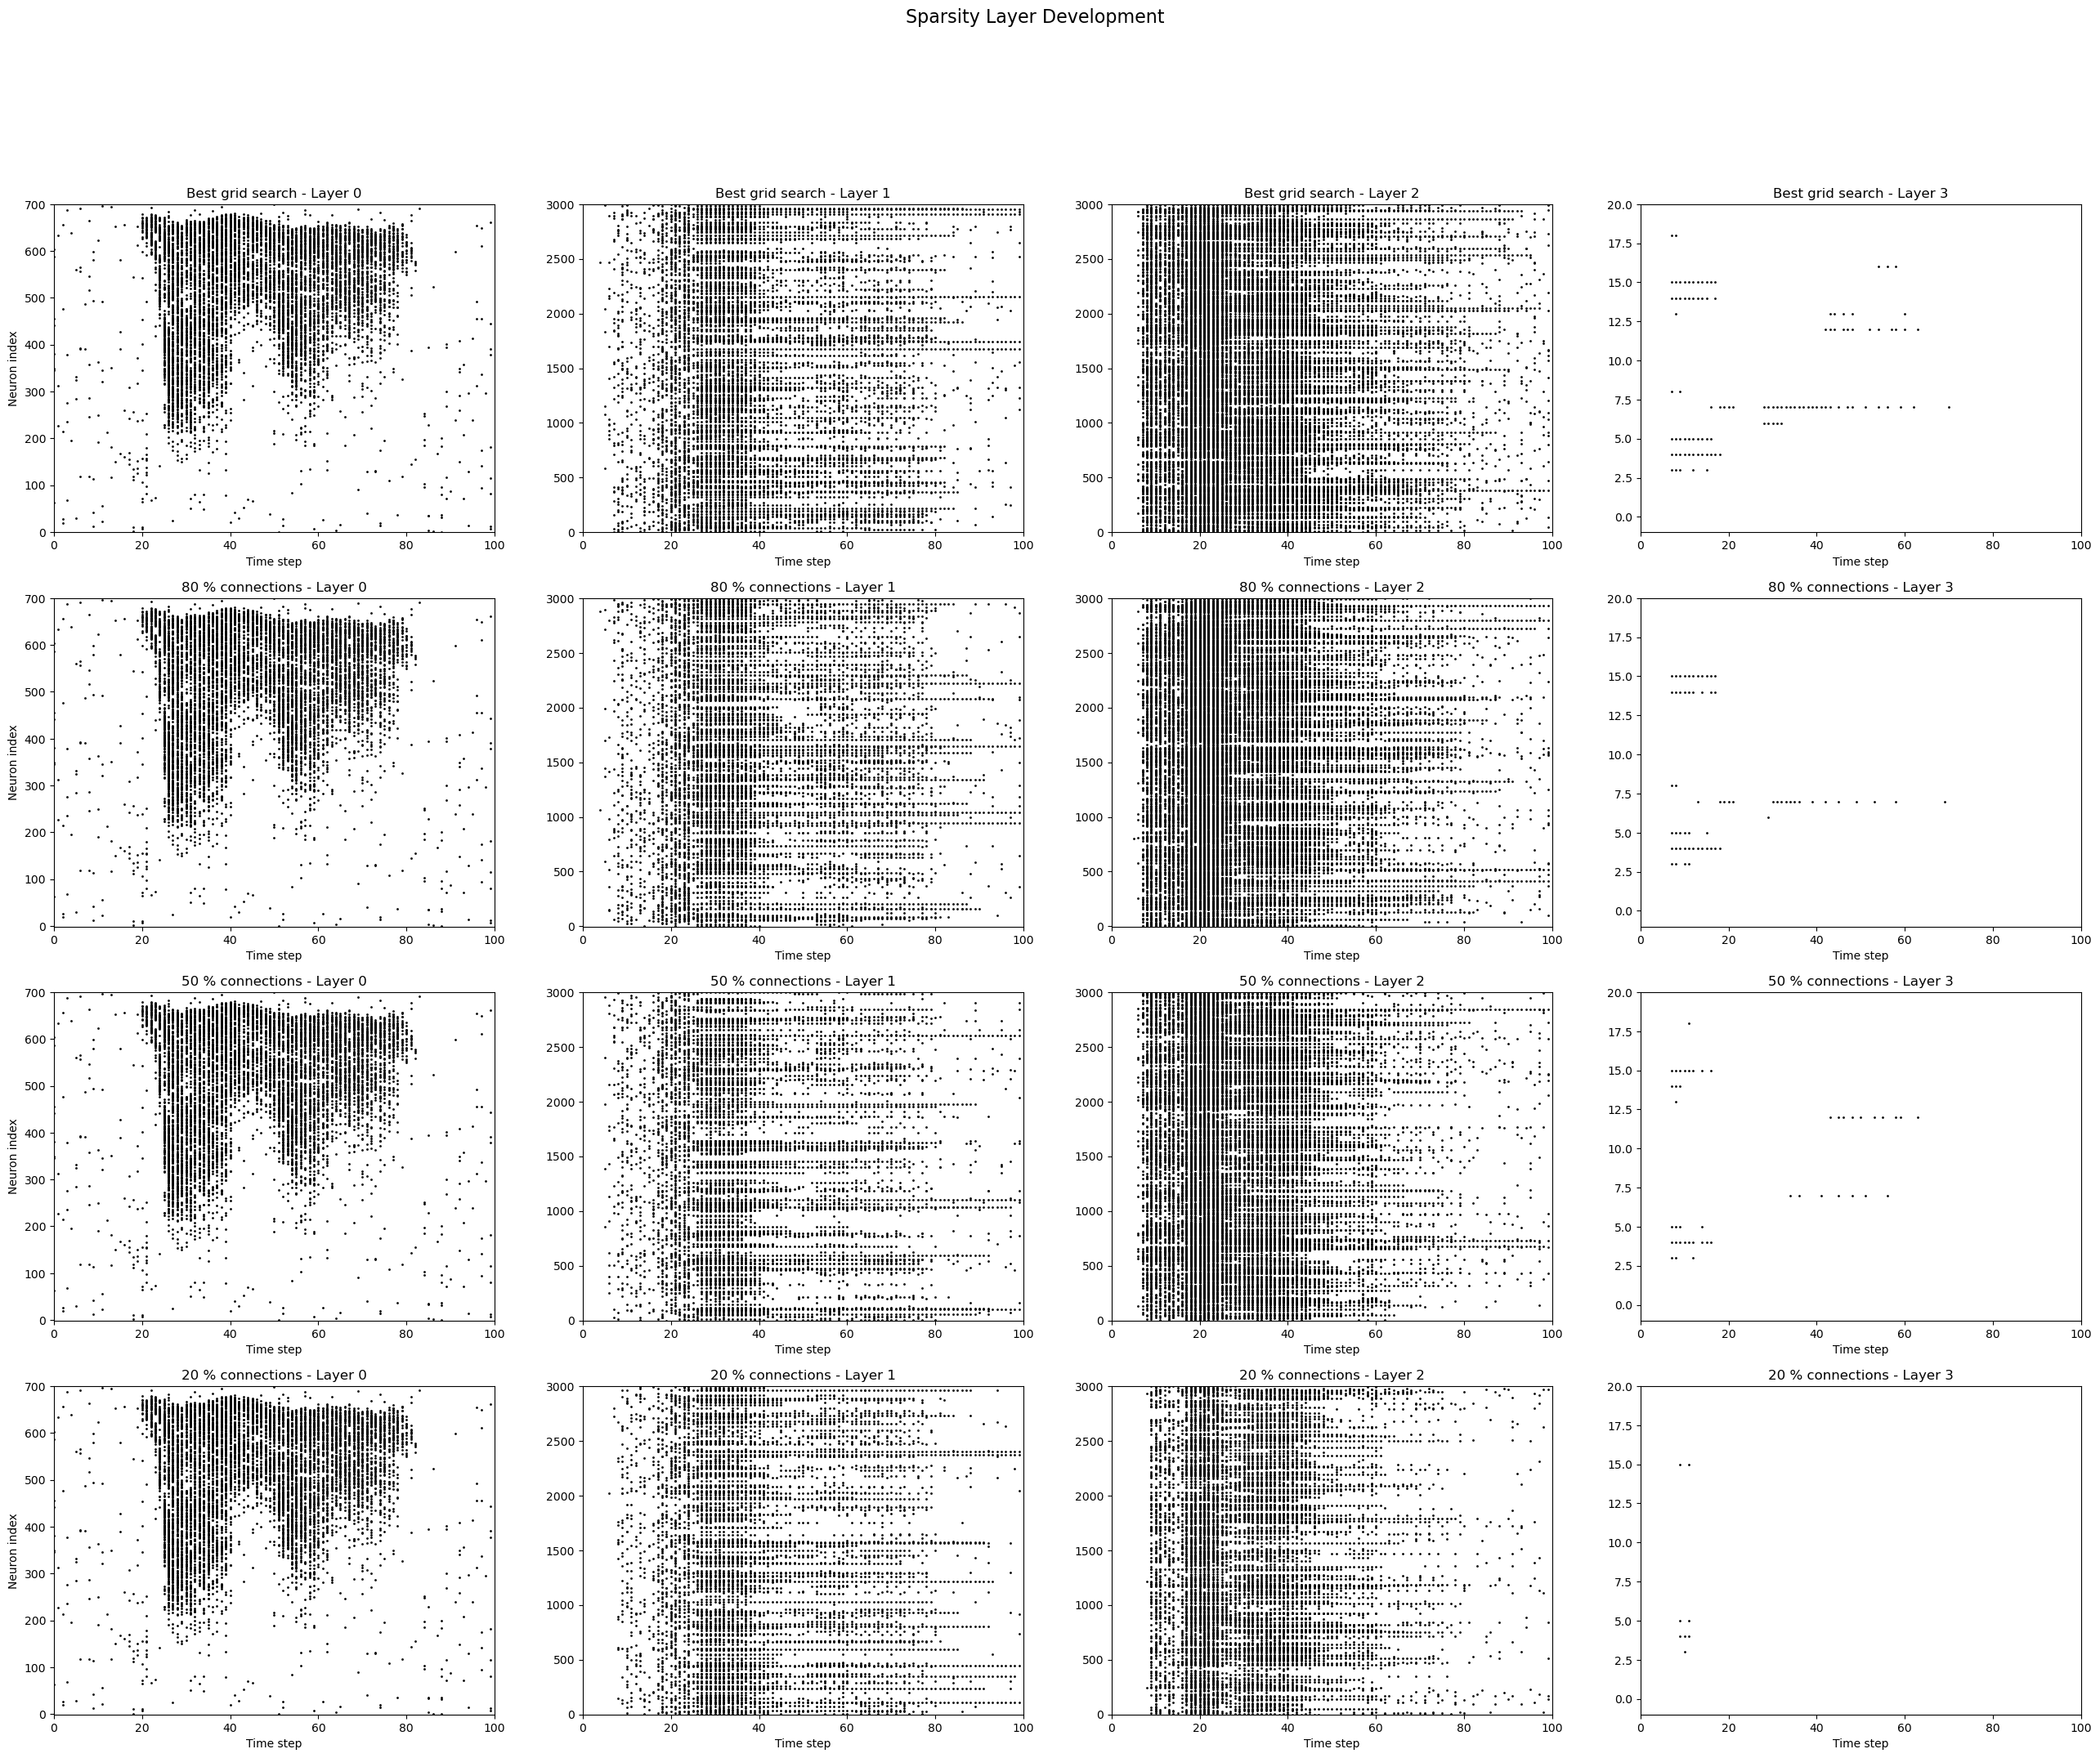

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spike_matrices_best_grid_search = get_spk_matrices(data, best_grid_search_model, selection_index)
spike_matrices_best_grid_search_80_percent = get_spk_matrices(data, best_grid_search_model_80_percent_of_connections, selection_index)
spike_matrices_best_grid_search_50_percent = get_spk_matrices(data, best_grid_search_model_50_percent_of_connections, selection_index)
spike_matrices_best_grid_search_20_percent = get_spk_matrices(data, best_grid_search_model_20_percent_of_connections, selection_index)
spike_matrices_best_grid_search_5_percent = get_spk_matrices(data, best_grid_search_model_5_percent_of_connections, selection_index)

fig, axes = plt.subplots(4, len(spike_matrices_best_grid_search), figsize=(40, 32))

fig.suptitle("Sparsity Layer Development", fontsize=16)

for index in range(len(spike_matrices_best_grid_search)):
    spike_matrix_np = spike_matrices_best_grid_search[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[0, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"Best grid search - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)
    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_80_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[1, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"80 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)
    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_50_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[2, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"50 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)
    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_20_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[3, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"20 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)

    if index == 0:
        ax.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_best_grid_search_5_percent[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax = axes[3, index]
    ax.scatter(times, neurons, s=1, color='black')
    ax.set_title(f"5 % connections - Layer {index}")
    ax.set_xlabel("Time step")
    ax.set_ylim(-1, spike_matrix_np.shape[1])
    ax.set_xlim(0, 100)

    if index == 0:
        ax.set_ylabel("Neuron index")

# LIF Parameter Evaluation

In [ ]:
def build_model_path(sparsity, beta, threshold):
    sparsity = '0' if sparsity == 0 else sparsity
    threshold = '1' if threshold == 1 else threshold
    return f'./models/experiment_layer_development_investigation/best_grid_search_sparsity_{sparsity}_beta_{beta}_threshold_{threshold}.pth'


In [ ]:
from glob import glob
import json
import pandas as pd

files = glob('./output/experiments_layer_development_investigation/*.json')

all_dicts = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)
        all_dicts.append(data)

evaluation = pd.DataFrame(all_dicts)

evaluation["average_training_time_per_epoch"] = evaluation["time"] / evaluation["epochs"]

evaluation = evaluation[(evaluation["beta"] > 0.5) & (evaluation["threshold"] < 3)]

evaluation = (evaluation.sort_values("sparsity", ascending=False))[["epochs", "test_accuracy", "sparsity", "beta", "threshold", "average_training_time_per_epoch"]]

evaluation

In [ ]:
import matplotlib.pyplot as plt

group_y = []
group_labels = []

x = [0, 0.2, 0.7, 0.95]

plt.figure(figsize=(8, 4))

for group_keys, group_df in evaluation.groupby(["beta", "threshold"]):
    group_df = group_df.sort_values("sparsity")
    group_y.append(group_df["test_accuracy"].to_numpy())
    group_labels.append(f'beta = {group_keys[0]} | threshold = {group_keys[1]}')

plt.title("Test Accuracy different sparsities and different LIF configurations")
plt.xlabel("Sparsity")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0, 0.2, 0.7, 0.95])

for y, label in zip(group_y, group_labels):
    plt.plot(x,y, marker='o', label=label)

plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

group_y = []
group_labels = []

x = [0, 0.2, 0.7, 0.95]

plt.figure(figsize=(8, 4))

for group_keys, group_df in evaluation.groupby(["beta", "threshold"]):
    group_df = group_df.sort_values("sparsity")
    group_y.append(group_df["average_training_time_per_epoch"].to_numpy())
    group_labels.append(f'beta = {group_keys[0]} | threshold = {group_keys[1]}')

plt.title("Average Training time per epoch over different sparsities and different LIF configurations")
plt.xlabel("Sparsity")
plt.ylabel("Average Training time per epoch")
plt.xticks(ticks=[0, 0.2, 0.7, 0.95])

for y, label in zip(group_y, group_labels):
    plt.plot(x,y, marker='o', label=label)

plt.legend()
plt.show()

In [ ]:
def count_zeros(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            numel = param.numel()
            zeros = torch.sum(param == 0).item()
            total_params += numel
            zero_params += zeros
    print(f"\nTotal sparsity: {100.0 * zero_params / total_params:.2f}% ({zero_params}/{total_params})")


In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

beta = 0.8
threshold = 0.7

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    count_zeros(model)
    models.append(model)

plot_layer_development(models, [f'sparsity = {sparsity}' for sparsity in sparsities], super_title='Beta = 0.8 | Threshold = 0.7')

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

beta = 0.8
threshold = 1

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    count_zeros(model)
    models.append(model)

plot_layer_development(models, [f'sparsity = {sparsity}' for sparsity in sparsities], super_title='Beta = 0.8 | Threshold = 1')

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

beta = 0.99
threshold = 0.7

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

sparsities = [0, 0.2, 0.7, 0.95]

base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=beta,
                                                 threshold=threshold,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYER)

models = []

for sparsity in sparsities:    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    count_zeros(model)
    models.append(model)

plot_layer_development(models, [f'sparsity = {sparsity}' for sparsity in sparsities], super_title='Beta = 0.99 | Threshold = 0.7')

In [ ]:
from util.plot_layer_development import plot_layer_development
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
import copy
import torch

sparsity = 0.95

lif_configurations = [
    (0.99, 1),
    (0.99, 0.7),
    (0.8, 1),
    (0.8, 0.7),
]

NUMBER_HIDDEN_NEURONS = 3000
NUMBER_HIDDEN_LAYER = 2

models = []

for beta, threshold in lif_configurations:    
    
    base_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                    number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                    number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                    beta=beta,
                                                    threshold=threshold,
                                                    time_steps=TIME_STEPS,
                                                    number_hidden_layers=NUMBER_HIDDEN_LAYER)
    
    model = copy.deepcopy(base_net)
    model_path = build_model_path(sparsity, beta, threshold)
    print(model_path)
    model.load_state_dict(torch.load(model_path))

    models.append(model)

plot_layer_development(models, [f'beta = {beta} | threshold = {threshold}' for beta, threshold in lif_configurations], super_title=f'Sparsity = {sparsity}')